# Qiskit tests
## Creation of a circuit that implements HHL for Toeplitz symmetrical tridiagonal matrix 

This notebook is based in 2 papers:

- [1] : Harrow, A. W., Hassidim, A., Lloyd, S. (2009). Quantum algorithm for linear systems of equations. Phys. Rev. Lett. 103, 15 (2009), 1–15. <https://doi.org/10.1103/PhysRevLett.103.150502>
- [2] : Carrera Vazquez, A., Hiptmair, R., & Woerner, S. (2020). Enhancing the Quantum Linear Systems Algorithm using Richardson Extrapolation.arXiv:2009.04484 <http://arxiv.org/abs/2009.04484>`

The circuit construction and the functions used in this notebook can be found on the file <a href=hhl_functions.py>hhl_functions.py</a>, however, all this functions contain descriptions and should be intuitive to use.

This notebook is the main production notebook. Here I try the things before importing them into a separate file

In [7]:
import numpy as np
from typing import Optional
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev  
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from numpy_matrix import NumPyMatrix
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from itertools import product
from hhl_functions import *

In [7]:
# Solve circuit
def solve(qc: QuantumCircuit):
    solution = 0
    return solution

---
# **Test**

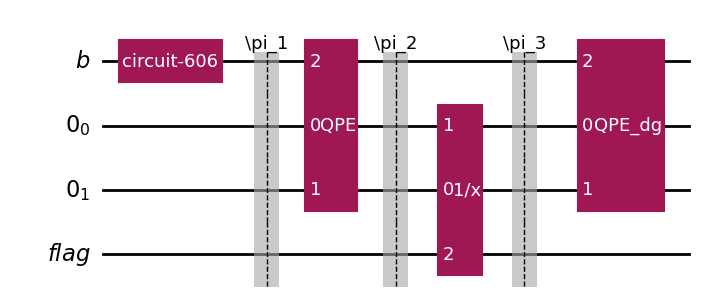

In [12]:
vector = np.array([1,1])
matrix = tridiag_matrix(2,-1,2)

hhl,scaling = build_circuit(matrix,vector,10e-2,flag=True)
hhl.draw('mpl')

# Code to print the circuit into latex code
# tes=hhl.draw('latex_source')
# f = open('aux.tex','a+')
# f.write(tes)
# f.close()

# hhl_d = hhl.decompose(reps=6)

# hhl_d.draw('mpl')


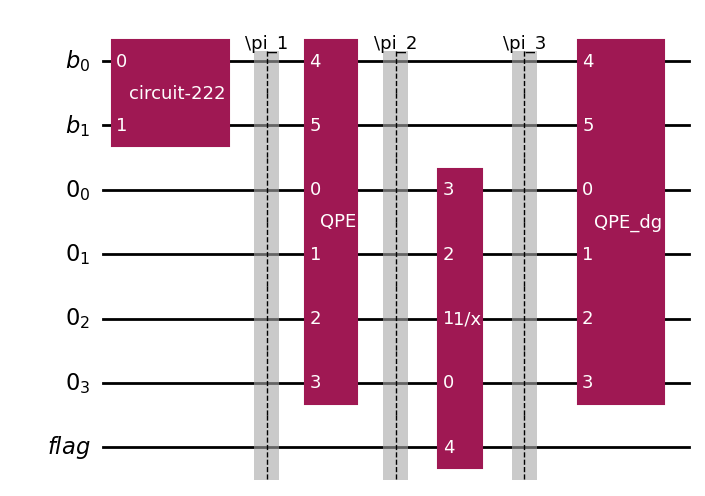

In [13]:
vector = np.array([1]*4)
matrix = tridiag_matrix(2,-1,4)
hhl,_ = build_circuit(matrix,vector,flag=True)
hhl.decompose(reps=0).draw('mpl')

-----
We can test the circuit using statevectors

In [14]:
sol1=solution(hhl)
print(sol1)

[0.39206738 0.5884583  0.5884583  0.39206738]


Exact solution

In [15]:
sol=np.linalg.solve(matrix,vector/np.linalg.norm(vector))
sol/np.linalg.norm(sol)
norm=np.sqrt(sum(sol**2))

sol2=sol/norm
print(sol2)

[0.39223227 0.58834841 0.58834841 0.39223227]


If we have a 2-dimensional vector, the solution with statevectors is exact (we only have one qubit for $b$). But as we increase the dimension, the solution worsens

In [16]:
diff = np.abs(sol1-sol2)
print(f'The difference is: {diff}')
MSE = np.linalg.norm(diff)
print(f'The norm of the diff is: {MSE}')

The difference is: [0.00016489 0.00010989 0.00010989 0.00016489]
The norm of the diff is: 0.000280227056225066


-----
## Simulation with shots

In [17]:
def prob_from_counts_hhl(counts,shots: int, repeat) -> np.ndarray:
    """ Calculates the expected amplitudes of the solution |x> without normalization
    
    Args:
        `counts`: Counts as a dictionary {'xxxxx': number}, obtained from a simulation or run in a real QPU
        `shots`: Number of shots (runs) of the circuit
        `repeat`: Number of qubits used to represent the right-hand side vector in the system
    Returns:
        The non normalized amplitudes of the solution. To get the real solution, you should normalize it and multiply it by the norm of the solution.
    """ 
    if not isinstance(repeat,int):
        repeat = int(repeat)
        
    all_outcomes = [''.join(outcome) for outcome in product('01', repeat=repeat)]

    # Initialize the dictionary with each binary string as a key and a value of 0
    prob_amplitudes = {outcome: 0 for outcome in all_outcomes}

    for outcome, count in counts.items():
        first_qubit_state = outcome[-repeat:]  # Get the state of the first qubit
        prob_amplitudes[first_qubit_state] += count / shots

    ampl = np.array(list(prob_amplitudes.values()))
    return ampl

Estimated amplitudes of the solution: [0.16149902 0.34008789 0.33032227 0.16809082]


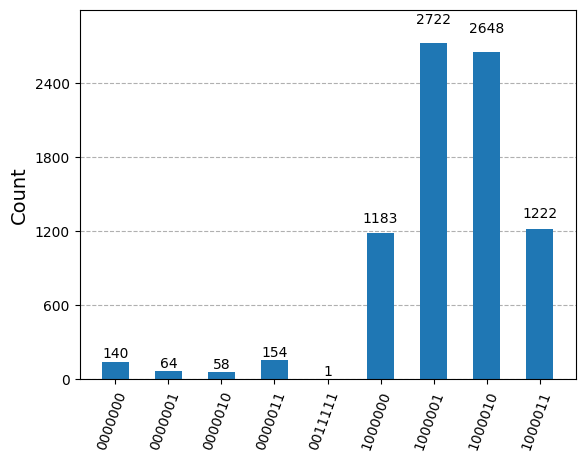

In [18]:
sim = AerSimulator()
hhl_meas,_ = build_circuit(matrix,vector,10e-4,True,True)
hhl_meas = transpile(hhl_meas,sim)

sampler = SamplerV2()

shots = 8192

job = sampler.run([hhl_meas],shots=shots)
job_result = job.result()

counts=job_result[0].data.meas.get_counts()

prob_amplitudes = prob_from_counts_hhl(counts,shots,np.log2(len(vector)))

print("Estimated amplitudes of the solution:", prob_amplitudes)

plot_histogram(job_result[0].data.meas.get_counts())

Una vez tenemos las amplitudes calculadas, podemos ver su distancia con el valor real del problema. Para poder compararlas, debemos hacer $\frac{\vec{x}}{||\vec{x}||}$, sobre el diccionario de valores

In [19]:
ampl = prob_amplitudes/np.linalg.norm(prob_amplitudes)

# Calculate the difference
diff = np.abs(ampl-sol2)
print(f'The difference is: {diff}')
MSE = np.linalg.norm(diff)
print(f'The norm of the diff is: {MSE}')

The difference is: [0.08654106 0.0553823  0.03689757 0.07406386]
The norm of the diff is: 0.13192209839331057


Pruebas distintas de observables

In [20]:
from qiskit_aer.primitives import SamplerV2

sim = AerSimulator()
hhl_meas = hhl
hhl_meas.measure_all()

hhl_meas = transpile(hhl,sim)

sampler = SamplerV2()
shots = 8192

job = sampler.run([hhl_meas],shots=shots)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()
filtered_counts = {k: v for k, v in counts.items() if k[0] == '1'}
total_filtered_counts = sum(filtered_counts.values())
norm_b = np.linalg.norm(vector)

P1 = total_filtered_counts/shots
eigs = np.linalg.eigvals(matrix)
nl = hhl.qregs[1].size
C = get_delta(nl,min(eigs),max(eigs))*2**nl
c = 1

norm_x = (P1/(C**2))**0.5

print(f'||x|| = {norm_x}')


||x|| = 0.9732757188998398


---
## Error de la solución

Se tendrá que, siendo $\vec{x}$ la solución del problema con el vector de lados derechos normalizada, $\vec{x}'$ el vector resultante del problema, se tredrá que $\vec{x}=\frac{||\vec{x}||\cdot\vec{x}'}{||\vec{x}'||}$. Por lo tanto, utilizando el observable indicado en [2] además de los valores obtenidos, podremos obtener este valor.

In [21]:
sol_e = np.linalg.solve(matrix,vector)
np.linalg.norm(sol_e)**2

25.999999999999996

El error daba errores, así que voy a pasar de ello un poco de momento

---

## Paralellization of circuits